# COGS 108 - Capstone Project
## Group Members:
- Vincent Tierra   - A12654756
- Adrian Herrmann  - A14202007
- Lynley Yamaguchi - A12209358



# Introduction and Background

For most people, getting the flu means congestion, coughing, and bed-ridden fatigue for up to a week or two. The advent of modern medicine has reduced the illness from a lethal plague to a mere inconvenience. However, most of modern society has little fear for the flu, the illness still claims the lives of a surprising number of the population each year, which begs the question of how such a typically trivial ailment could have such serious effects on some. What separates those unlucky few from the rest?

This past flu season, San Diego County recorded a staggering 85 influenza-related deaths along with 105 influenza-related ICU cases (HSSA). Our group was curious to see if a socioeconomic pattern might exist between these cases. If the data reveals that these occurrences are segregated to a particular demographic of people, the cause of the problem may be much more easily diagnosed and even prevented, by providing the proper aid to that demographic.

A study by the Yale School of Public Health found that “residents of neighborhoods with high number of people living below the poverty line are twice as likely to be hospitalized for influenza” (Meyer). While their study is very similar to ours, the Yale School primarily studied a Connecticut site which differs from San Diego in a number of parameters including demographic distribution and climate. If our analysis yields a similar result, Yale School’s findings would support our hypothesis that higher flu mortality is linked to lower income regions, irrespective of race or weather variables.

To analyze the data for our research question, we will pull out the data such as flu rate (hospitalization and discharge), the population in poverty, economic background, and population density. Utilizing the pandas library, we will compress the flu rate, median income and other values into regions with various hospitals. We will Try figuring out if income does indeed hold a significant impact on the spread of communicable diseases, specifically the flu. Using the t-test where discharge/hospitalization rate is dependent on income/poverty and other possible confounds with a confidence level of 0.05. We will then further our analysis by providing techniques to predict the flu rate dependent on the income of where an individual lives.

# Data Description

- Dataset Name: Communicable Diseases (Flu Hospitalizations, Flu EDD)
- Link to the dataset: http://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_health_statistics/regional-community-data.html
- Number of observations: 41 (regions)

The datasets on Communicable Diseases includes the number of flu hospitalizations and emergency department discharges per geographical area in San Diego. Information on the sex, race, and age range of the patients are also included.


- Dataset Name: 2015 Demographic Profiles (Poverty Level, Income and Benefits)
- Link to the dataset: http://www.sandiegocounty.gov/content/dam/sdc/hhsa/programs/phs/CHS/demographics/2015_Demographic_Profiles.pdf
- Number of observations: 41 (regions)

The datasets on Demographic Profiles include, per geographical area in San Diego County, the percentage of the population that is below the Federal Poverty Level, the total number of households, and the average household income.

We ended up storing all our data into a single DataFrame. Including the median person per household income, important since this is the average income each person has in a given region and can be compared to the flu discharge and hospitalization rate. We need median income because it's the best way to capture central tendancy of income, which tends to be positively skewed.

The flu discharge and hospitalization rates normalizes the population, which is important because we can't simply use the total number which the population would largely effect. This makes data appropriately comparable over every region.

The amount of people of a given region in poverty is represented which does correlate with income but adds another interesting layer to look at since some areas with a higher median income still have more people in poverty than somewhere with a lower income.

Finally we have the geography data. This tells us what to distribute the data into, each geography represents all of the above; discharge rate, hospitalization rate, median income per person, and poverty level. Each region is what is ultimately being grouped and compared.

In [1]:
# Imports -  These are all you need for the assignment: do not import additional packages
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind

# Loading & Cleaning the Data
    
Read in the following csv files:
- Flu discharge rate by region
- Flu hospitalization rate by region
- Population below 100% poverty level by region
- Median income per person household by region  

In [2]:
# Import the data from the files into Dataframes

df_edd = pd.read_csv('FluEDD.csv')
df_h = pd.read_csv('FluHospitalization.csv')
df_poverty = pd.read_csv('SDPoverty.csv')
df_median_income = pd.read_csv('SDMedianIncome.csv')

Clean the data:

- Replace empty values with 0
- Drop unnecessary columns
- Group duplicate values in region

In [3]:
# Replace NaN values with 0 

df_edd.fillna(value=0, inplace=True)
df_h.fillna(value=0, inplace=True)
df_poverty.fillna(value=0,inplace=True)

In [4]:
# Drop unnecessary columns in hospital and discharge dataframe
df_h.drop(['CONDITION', 'OUTCOME'], axis=1, inplace=True)
df_edd.drop(['CONDITION', 'OUTCOME'], axis=1, inplace=True)

In [5]:
# Drop unnecessary columns in poverty dataframe
df_p = df_poverty.drop(['Families below poverty level','Families with children under 18 years below poverty level'], axis=1)

# Drop unnecessary columns in median income dataframe
df_median_income.drop(['median_household_income', 'persons_per_household'], axis = 1, inplace = True)
df_median_income = df_median_income[df_median_income['Geography'] != 'San Diego County']

In [6]:
# Create Dataframe with needed columns
df_h = df_h[['YEAR', 'Geography', 'RegionName', 'Total_Rate']]
df_edd = df_edd[['YEAR', 'Geography', 'RegionName', 'Total_Rate']]

# Group the Geographies to get the average rate over all 4 years (for mean)
df_h_mean = df_h.drop('YEAR', axis=1)
df_edd_mean = df_edd.drop('YEAR', axis=1)
df_h_mean = df_h_mean.groupby(['Geography', 'RegionName'], as_index=False).mean()
df_edd_mean = df_edd_mean.groupby(['Geography', 'RegionName'], as_index=False).mean()

# Drop regions which are only the total of other regions (repetitive)
df_h_mean.drop([3, 9, 25, 26, 27, 36, 41], axis = 0, inplace=True)
df_h_mean = df_h_mean.reset_index(drop=True)
df_edd_mean.drop([3, 9, 25, 26, 27, 36, 41], axis=0, inplace=True)
df_edd_mean = df_edd_mean.reset_index(drop=True)
df_p_mean = df_p.drop([0, 4, 16, 24, 30, 41], axis = 0)
df_p_mean = df_p_mean.reset_index(drop = True)

Further organize data:

- Rename columns to the standard
- Merge datasets all into one called df
- Manually enter missing values because dataset is not very large
    - Can't afford to omit this data
- Remove rows with zeros in both hospitalization and discharge
    - These areas may have not been recorded and could skew the data

In [7]:
# Rename the total rate for h and edd
df_h = df_h.rename(columns={ 'Total_Rate' : 'total_rate_h'})
df_edd = df_edd.rename(columns={ 'Total_Rate' : 'total_rate_edd'})
df_h_mean = df_h_mean.rename(columns={ 'Total_Rate' : 'total_rate_h'})
df_edd_mean = df_edd_mean.rename(columns={ 'Total_Rate' : 'total_rate_edd'})

In [8]:
# Merge flu case, poverty, and median income data into one Dataframe
df = df_median_income.merge(df_h_mean.merge(df_edd_mean, how='left', on=['Geography', 'RegionName']), how='right', on='Geography')
df = df_p_mean.merge(df, how='right', on='Geography')
df.rename(columns={'Geography': 'geography', 'RegionName' : 'region_name',  'Population below 100% federal poverty level (FPL)' \
                   : 'poverty_pop'}, inplace=True)

# For separate years
# Merge hospital data and poverty data into one Dataframe
df_hp = pd.merge(df_h,df_p,on='Geography')

# Manually enter some missing data
df.set_value(40, 'pph_income', 27040 + 19341)
df.set_value(39, 'pph_income', 33196)
df.set_value(40, 'poverty_pop', 10.3 + 21.8)
df.set_value(39, 'poverty_pop', 6.7)
df.set_value(38, 'poverty_pop', 24.5)
df.set_value(37, 'poverty_pop', 5.1)
df.set_value(36, 'poverty_pop', 11.5)
df.dropna(inplace=True)

In [9]:
# Clean the dataset incase of missing values to avoid skewing
df = df[(df['total_rate_h'] != 0) | (df['total_rate_edd'] != 0)]
df = df.reset_index(drop=True)

# Display the combined dataset for the mean rate over years
df

,geography,poverty_pop,pph_income,region_name,total_rate_h,total_rate_edd
0,Central San Diego,20.9,30516.0,CENTRAL,11.378619,69.931862
1,Mid-City,26.1,17541.0,CENTRAL,12.626990,84.877651
2,Southeastern San Diego,21.6,14444.0,CENTRAL,12.424052,111.980785
3,Alpine,8.7,31613.0,EAST,0.000000,37.622708
4,El Cajon,21.8,19341.0,EAST,13.295462,62.213675
5,Jamul,7.8,35779.0,EAST,0.000000,86.859562
6,La Mesa,12.0,24951.0,EAST,19.122542,70.301535
7,Lakeside,11.1,25063.0,EAST,3.058264,43.094199
8,Lemon Grove,15.2,19266.0,EAST,11.622501,90.653971
9,Mountain Empire,21.2,19672.0,EAST,0.000000,17.466232


# Data Exploration

## Visualization

Plot various data:

- Plot a scatter matrix to get a feel for the data
- Plot a correlation matrix to see if it looks like there will be significant correlations early one
- Plot various histograms to get a general understanding for the data

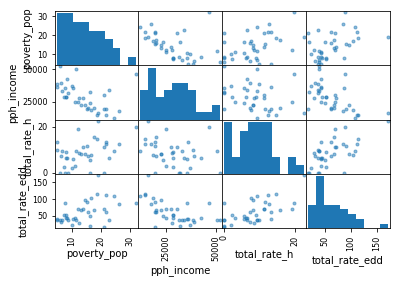

In [10]:
# Plot the scatter matrix for all data
fig = pd.scatter_matrix(df)

From the scatter matrix we can roughly make out some correlations, let's more clearly see how strong they are in a heatmap.

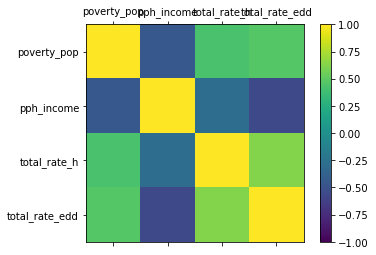

In [11]:
# Define correlations and columns
correlations = df.corr()
columns = ['poverty_pop', 'pph_income', 'total_rate_h', 'total_rate_edd']

# Plot the correlation matrix
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(columns)
ax.set_yticklabels(columns)
plt.show()

The heatmap tells us early on that there are some light correlations, one of the stronger being discharge rate and median income which are negatively correlated. So far things are looking good.

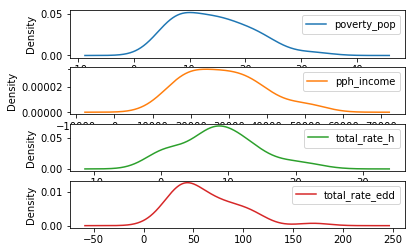

In [12]:
# Use density plots to view the data
df.plot(kind='density', subplots=True, sharex=False)
plt.show()

We can see each of the columns of data follow a rough normal distribution. Their histograms give us some more details

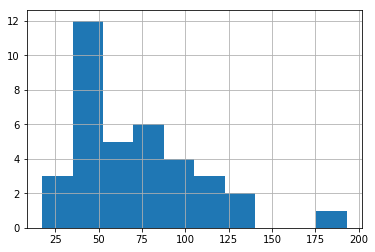

In [13]:
# Plot histogram for hospitalized and discharged patients as one
df['total_rate_h'].add(df['total_rate_edd']).hist()

f1 = plt.gcf

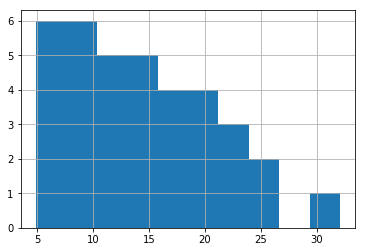

In [14]:
# Plot histogram for poverty
df['poverty_pop'].hist()

f2 = plt.gcf

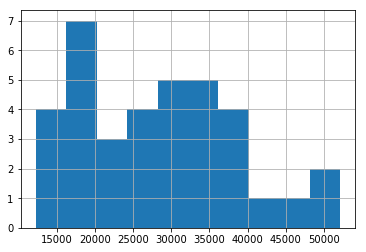

In [15]:
# Plot histogram for person per household income
df['pph_income'].hist()

f3 = plt.gcf

## Exploring The Data

Here we calculate the ratio of hospitalization to discharge below and above the mean and find that they are fairly close to one another. This may mean hospitalization increases at the same rate as discharge in areas greater effected.

In [16]:
# Split incomes into below and above the median
income_median = df['pph_income'].median()
df_income_below = df[df['pph_income'] < income_median]
df_income_above = df[df['pph_income'] >= income_median]

In [17]:
# Calculate the ratio between hospitalized and discharged patients
ratio_below = df_income_below['total_rate_h'].mean()/df_income_below['total_rate_edd'].mean()
ratio_above = df_income_above['total_rate_h'].mean()/df_income_above['total_rate_edd'].mean()

In [18]:
# Print the ratios
print('Ratio hospitalization to discharge rate in areas below the mean: ', ratio_below)
print('Ratio hospitalization to discharge rate in areas above the mean: ', ratio_above)

Ratio hospitalization to discharge rate in areas below the mean:  0.1345638539137013
Ratio hospitalization to discharge rate in areas above the mean:  0.14382163094032022


The values held in areas with maximum and minimum poverty and median income are displayed

In [19]:
# Determine the area with the lowest and highest income
max_i = df['poverty_pop'].idxmax
min_i = df['poverty_pop'].idxmin

# print out the information of these areas
print('Area With Greatest Population in Poverty: ' + str(df.loc[max_i, 'geography']) + '\nPerson Per Household Income: ' + \
      str(df.loc[max_i, 'pph_income']) + '\nFlu Hospitalization Rate: ' + str(df.loc[max_i, 'total_rate_h']) + \
      '\nFlu Discharge Rate: ' + str(df.loc[max_i, 'total_rate_edd']))

print('\nArea With Lowest Population in Poverty: ' + str(df.loc[min_i, 'geography']) + '\nPerson Per Household Income: ' + \
      str(df.loc[min_i, 'pph_income']) + '\nFlu Hospitalization Rate: ' + str(df.loc[min_i, 'total_rate_h']) + \
      '\nFlu Discharge Rate: ' + str(df.loc[min_i, 'total_rate_edd']))

Area With Greatest Population in Poverty: Harbison Crest/El Cajon
Person Per Household Income: 46381.0
Flu Hospitalization Rate: 19.7162381125
Flu Discharge Rate: 89.583516245

Area With Lowest Population in Poverty: North San Diego
Person Per Household Income: 36284.0
Flu Hospitalization Rate: 13.33475445
Flu Discharge Rate: 42.3066855725


The area with the greatest poverty population has a higher median income but that's only because the area has a greater population itself. What is interesting though is that the flu discharge rate is greater in this area too.

In [20]:
# Determine the area with the lowest and highest income
max_i = df['pph_income'].idxmax
min_i = df['pph_income'].idxmin

# print out the information of these areas
print('Area With Greatest Income: ' + str(df.loc[max_i, 'geography']) + '\nPerson Per Household Income: ' + \
      str(df.loc[max_i, 'pph_income']) + '\nFlu Hospitalization Rate: ' + str(df.loc[max_i, 'total_rate_h']) + \
      '\nFlu Discharge Rate: ' + str(df.loc[max_i, 'total_rate_edd']))

print('\nArea With Lowest Income: ' + str(df.loc[min_i, 'geography']) + '\nPerson Per Household Income: ' + \
      str(df.loc[min_i, 'pph_income']) + '\nFlu Hospitalization Rate: ' + str(df.loc[min_i, 'total_rate_h']) + \
      '\nFlu Discharge Rate: ' + str(df.loc[min_i, 'total_rate_edd']))

Area With Greatest Income: Coronado
Person Per Household Income: 52151.0
Flu Hospitalization Rate: 0.0
Flu Discharge Rate: 38.46987107

Area With Lowest Income: National City
Person Per Household Income: 12209.0
Flu Hospitalization Rate: 9.3896874575
Flu Discharge Rate: 108.819230885


Here at the extreme values the flu hospitalization and discharge rate fit our predictions.

## Part 4: Data Analysis

Using the t-test to determine a significant difference
- We do not have two separate distributions to test yet, so we must make them
    - First we find the means of discharge and hospitalization rate
    - Next we split areas into those below and above this mean
    - We now have two distributions to compare with a t-test

In [21]:
# Calculate the means for hospitalized and discharged patients
h_rate_median = df['total_rate_h'].median()
edd_rate_median = df['total_rate_edd'].median()

In [22]:
# Print the means
print("Median flu hospitalization rate: ", h_rate_median)
print("Median flu discharge rate: ", edd_rate_median)

Median flu hospitalization rate:  8.329816449
Median flu discharge rate:  51.9290756125


In [23]:
# Create DataFrames for incomes below and above the mean rates
h_rate_below = df[df['total_rate_h'] < h_rate_median]['pph_income']
h_rate_above = df[df['total_rate_h'] >= h_rate_median]['pph_income']
edd_rate_below = df[df['total_rate_edd'] < edd_rate_median]['pph_income']
edd_rate_above = df[df['total_rate_edd'] >= edd_rate_median]['pph_income']

In [24]:
# Use t-test on incomes of areas below or above mean discharge and hospitalization rates
t, p_h = ttest_ind(h_rate_above, h_rate_below)
t, p_edd = ttest_ind(edd_rate_above, edd_rate_below)

In [25]:
# Print the p-values
print('Hospitalization two-tailed p-value: ', p_h)
print('Discharge two-tailed p-value: ', p_edd)

Hospitalization two-tailed p-value:  0.254059873579
Discharge two-tailed p-value:  0.000321106320269


The p-value of the hospitalization rate is not low enough to rely on. This could be due to areas with lower income having greater need for hospitalization but less money to justify the cost.

The p-value of the discharge rate is fairly low, indicating median income in areas with high vs low discharge rates are significantly different. Let's create a linear model and print out the summary between flu discharge rate and income.

In [26]:
# Create linear model to predict discharge rate from income
outcome_1, predictors_1 = patsy.dmatrices('total_rate_edd ~ pph_income', df2)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

NameError: name 'df2' is not defined

In [27]:
print(res_1.summary())

NameError: name 'res_1' is not defined

Since the flu is a communicable disease, we want to check if population size makes a difference. Areas with lower income may simply have a denser population which would give a third variable problem.

We will:
- load the csv data for population in different regions of San Diego
- Merge the population DataFrame into df2
    - Some rows will be lost so we do not want to keep using the dataset including population
- Calculate the population mean
- use the t-test dependent on income and population

In [28]:
# Import the population data
df_pop = pd.read_csv('SDPopulation.csv')

# Merge in separate DataFrame to avoid losing more data
df2 = df.merge(df_pop, on='geography')

In [29]:
# Retrieve and print the population mean
pop_mean = df2['population'].mean()
print("The population mean per area in San Diego is: ", pop_mean)

The population mean per area in San Diego is:  89852.5


In [30]:
# Create another linear model, this time predicting discharge rate from income and population
outcome_2, predictors_2 = patsy.dmatrices('total_rate_edd ~ pph_income + population', df2)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

In [31]:
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:         total_rate_edd   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     13.59
Date:                Mon, 05 Jun 2017   Prob (F-statistic):           5.77e-05
Time:                        22:54:53   Log-Likelihood:                -156.23
No. Observations:                  34   AIC:                             318.5
Df Residuals:                      31   BIC:                             323.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    100.7031     16.625      6.057      0.0

This shows population is no real confound, but can also reasonably predict discharge rate.

Perhaps lower income areas do not check in at a hospital as often too due to cost or health insurance, but we do not have data that would let us check this, and it would only help our case if true. 

Also, hospitals in areas of lower income may have less hospitalization from people there not being able to afford it.

## Plot comparisons to a normal distribution

Our sample sizes are less than 50, so we do not have enough data to reject the null hypothesis; the number of samples are too small to find enough evidence of a normal distribution.

We can still compare to a normal distribution. and this data tells us that although a small sample size, it is still not too far from normal.

In [32]:
# Import functions for testing distributions, clustering, and dimensionality reduction.
import scipy.stats as stats
from scipy.stats import normaltest
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model

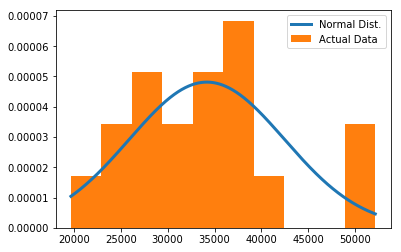

In [33]:
xs = np.arange(edd_rate_below.min(), edd_rate_below.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(edd_rate_below), np.std(edd_rate_below))
plt.plot(xs, fit, label='Normal Dist.', lw=3)
plt.hist(edd_rate_below, normed=True, label='Actual Data')
plt.legend()

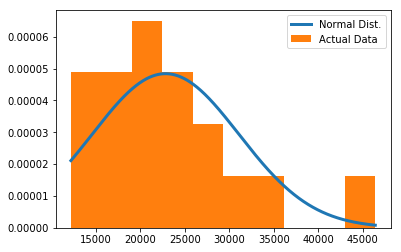

In [34]:
xs = np.arange(edd_rate_above.min(), edd_rate_above.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(edd_rate_above), np.std(edd_rate_above))
plt.plot(xs, fit, label='Normal Dist.', lw=3)
plt.hist(edd_rate_above, normed=True, label='Actual Data')
plt.legend()

## Clustering Income and discharge Rate

We are focusing on discharge rate since hospitalization most likely had other factors reducing its correlation with poverty and income. The kmeans cluster better shows the polarity between low and high discharge rates and income. It may not be as useful as linear regression here but an income value can well predict whether the rate of flu cases is high or low.

In [35]:
# Get required data
d1 = df['pph_income'].values
d2 = df['total_rate_edd'].values

In [36]:
# Whiten the data
d1w = whiten(d1)
d2w = whiten(d2)

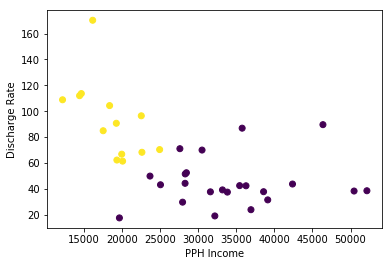

In [37]:
# Initialize kmeans, fit, and plot data
km = KMeans(n_clusters = 2, random_state = 42)
cl_dat = np.array([d1w, d2w]).T
km.fit(cl_dat)
plt.scatter(d1, d2, c=km.labels_)
plt.xlabel('PPH Income')
plt.ylabel('Discharge Rate')

## Finding a linear regression fit

Here we find a regression fit between the discharge rate and income. This will be the best way to decently determine 

In [38]:
# Retrieve the data we need to fit
x_edd = df['total_rate_edd'].values.reshape(-1, 1)
y_income = df['pph_income'].values.reshape(-1, 1)

# Fit the model
regr = linear_model.LinearRegression()
regr.fit(x_edd, y_income)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

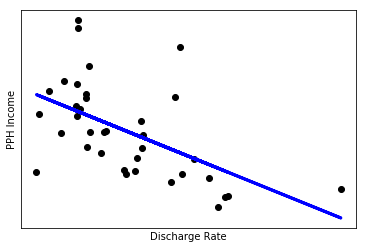

In [39]:
# Plot the linear regression model
plt.scatter(x_edd, y_income,  color='black')
plt.plot(x_edd, regr.predict(x_edd), color='blue',
         linewidth=3)
plt.xlabel('Discharge Rate')
plt.ylabel('PPH Income')
plt.xticks(())
plt.yticks(())

plt.show()

## Dimensionality Reduction

Combine the poverty rate with the discharge rate into one value.

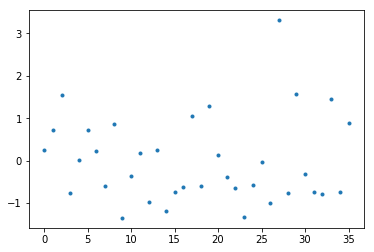

In [40]:
# Initialize the PCA model, here specifying 1 component
pca = PCA(n_components=1, whiten=True)
d1_h = df['total_rate_edd']
d2_p = df['poverty_pop']
dat = np.array([d1_h, d2_p]).T
out = pca.fit_transform(dat)
plt.plot(out, '.');

# Conclusion

We have high confidence we were able to find an accurate correlation. We could not think of many more confounds than the ones we already did, and the ones we did come up with ended up not affecting the dependency anyway. We used a t-test to check whether or not discharge rate is dependent on salary, which did end up turning out to be true. The hospitalization rate however did not have a significant enough value. We expect it's because people in lower income areas do not see the worth in spending extra money to remain in the hospital, which will balance high and low income areas rate. We also made sure population size, a large determinant in the spread of communicable diseases, did not affect the data to the same extent. Luckily, although it too was fairly effective at predicting the number of people with the flu, the poverty rate kept an even stronger correlation. Therefore, we were able to retain our hypothesis that the rate of flu cases and income have an affect on one another.

By nowing which areas are likely to have a greater flu outbreak we know where to promote free services like flu vaccinations. This does not solve the root of the problem but will lower its spread. It isn't completely obvious what the cause of the flu is, but we can assume some things common in places less priviliged. Lack of hygiene may be the greatest factor here. If someone can't afford water to clean themselves or a new change of clothes in a reasonable timeframe, they are much more likely to spread some communicable disease like the flu. Much of this part of solving the problem is up to those who work in public health and the government in general. Spreading safety measures to prevent spread of sickness and rising a region out of poverty are both very important.

Although we focused our project on the flu, we believe the same correlation would happen with any other communicable disease. So it spreads beyond this one sickness, giving this comparison an even greater significance. Although we focused our exploration on San Diego County alone, we are be interested in what the result spreading across the all of the United States would be like. More data can only give us more certainty on the end result.